# Tracking useful datasets

1. Start
    1. train_base
    1. census_data
2. Preprocessing
    1. train_base
    1. thin_census_data (converted form of census for join)
    

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [40]:
# Installation of libraries as required

!pip install sklearn

# Importing libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define custom functions or classes

In [42]:
# None required right now

# Pre-Processing data

1. Import the dataset
2. Generate high level summaries and pair plots

## Import data

In [43]:
train_base = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test_base = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

census_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample_submission = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

train_base.head(5)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [44]:
census_data.head(5)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [45]:
sample_submission.head(5)

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


#### Notes:

1. Additional census attributes need to be mapped through cfips attribute
2. Census data needs to be transformed into a thin format for usablity and joins
3. Census data is yearly, whereas the microbusiness data is monthly. We will need to keep this in ming when modelling later
4. Final submission needs a key based on cfips and date combination. Thus we will be working with 2 sets of keys to join and model data.
    1. cfips + full date
    2. cfips + year (for joining census data)

## Basic summary
We will try and understand the type of data we will work with

In [46]:
train_base.describe()

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,1.222650e+05
mean,30376.037640,3.817671,6.442858e+03
std,15143.508721,4.991087,3.304001e+04
min,1001.000000,0.000000,0.000000e+00
25%,18177.000000,1.639344,1.450000e+02
50%,29173.000000,2.586543,4.880000e+02
75%,45077.000000,4.519231,2.124000e+03
max,56045.000000,284.340030,1.167744e+06


In [47]:
train_base.isnull().any()

row_id                   False
cfips                    False
county                   False
state                    False
first_day_of_month       False
microbusiness_density    False
active                   False
dtype: bool

In [48]:
train_base.dtypes

row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

In [49]:
census_data.isnull().sum(axis = 0)

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1
median_hh_inc_2019       0
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

## Checks for preprocessing

1. Check if test data has more counties that need forecasting
2. Check if census data has missing counties
3. Validate if any target has missing values

In [50]:
# Identify any mismatch between train and test data

# Check if there are any missing counties

train_cfips = train_base['cfips'].unique()
test_cfips = test_base['cfips'].unique()

# Check if test data has additional counties
print([county for county in test_cfips if county not in train_cfips])

len(train_cfips), len(test_cfips)

[]


(3135, 3135)

In [51]:
# Check if census data is missing counties

census_cfips = census_data['cfips'].unique()

print([county for county in train_cfips if county not in census_cfips])

len(train_cfips), len(census_cfips)

[]


(3135, 3142)

In [52]:
# Check for missing values.
# Our targets are MBD and active variable, as these are missing from test data

temp = train_base.groupby('cfips')['microbusiness_density'].mean()
temp.sort_values()

cfips
28055     0.063846
13101     0.073227
51081     0.164327
29067     0.207466
46137     0.313856
           ...    
16021    46.730638
41061    54.522958
8105     60.942899
56033    73.510410
32510    87.196625
Name: microbusiness_density, Length: 3135, dtype: float64

## Pre-processing

1. Convert census data into thin format
1. Fill in the missing data in census data
1. Add relevant keys to census and train data
1. Validate if all keys are present in both datasets (helps determine potential upcoming missing values in data)

We may need to perform additional processing based on the validation results

### Transform census data

In [53]:
census_data_cols = census_data.columns.values

# We will use "_" to seperate each string and create a new thin dataframe
# This dataframe will be at a "cfips" and "year" level to enable join with the base dataset

temp = pd.DataFrame(census_data_cols, index= None)

temp.rename(columns = {0:"col_name"}, inplace = True)

# Remove cfips to make life easy

temp = temp.loc[temp['col_name'] != "cfips",:]

temp['year'] = temp['col_name'].str.slice(-4).astype('int')
temp['temp'] = "_"+temp['year'].astype('str')

#temp['new_col_name'] = temp['col_name'].str.replace(temp['temp'], "")
# Since expected method does not work, we will remove the last 5 characters for ease

temp['new_col_name'] = temp['col_name'].str.slice(start = 0, stop = -5).astype('str')

temp.drop(columns = ("temp"), inplace = True)
temp

,col_name,year,new_col_name
0,pct_bb_2017,2017,pct_bb
1,pct_bb_2018,2018,pct_bb
2,pct_bb_2019,2019,pct_bb
3,pct_bb_2020,2020,pct_bb
4,pct_bb_2021,2021,pct_bb
6,pct_college_2017,2017,pct_college
7,pct_college_2018,2018,pct_college
8,pct_college_2019,2019,pct_college
9,pct_college_2020,2020,pct_college
10,pct_college_2021,2021,pct_college


#### Convert census to thin format

We will run a loop to iterate through our gegerated columns, and append data to empty dataframe
We will summarize the dataframe to make format consistent without loss of data
Hopefully there is a better way to do this

In [54]:
new_cols = list(temp['new_col_name'].unique())

# Add the year and cfips columns 
new_cols.insert(0, ("year"))
new_cols.insert(0, ("cfips"))

# Make empty dataframe
thin_census_data = pd.DataFrame(columns = new_cols)

# Generate all possible combinations of cfips and year from just census data

for row in temp.itertuples():
    col_name = row.col_name
    year = row.year
    new_col_name = row.new_col_name
    
    # Make data to append/join
    temp_data = census_data.loc[:,("cfips",col_name)]# Get the required column along with IDs
    temp_data["year"] = year # Add year column
    
    temp_data = temp_data.loc[:,("cfips","year",col_name)] # Reorder columns for consistency
    temp_data.rename(columns = {col_name:new_col_name}, inplace = True)
    
    # Append data to out main dataframe
    thin_census_data = pd.concat((thin_census_data,temp_data), axis = 0)


# Summarize the dataset to get the final 
thin_census_data = thin_census_data.groupby(by = ["cfips","year"], as_index = False).first().reset_index()
thin_census_data.drop(columns = 'index', inplace = True)

thin_census_data.tail()

,cfips,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
15705,56045,2017,71.1,14.1,3.8,0.6,59605.0
15706,56045,2018,73.3,13.5,4.1,0.6,52867.0
15707,56045,2019,76.8,13.4,1.7,0.0,57031.0
15708,56045,2020,79.7,12.7,2.3,0.0,53333.0
15709,56045,2021,81.3,13.9,1.6,0.0,65566.0


#### Validate the transformed dataset

We will check if everything went smoothly using simple summaries across original and converted dataset

In [55]:
# Original summary
census_data.describe()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3142.000000,3141.000000,...,3142.000000,3141.000000,3142.000000,3141.000000,3141.000000,3142.000000,3141.000000,3142.000000,3140.000000,3140.000000
mean,69.920401,72.690866,75.398600,78.543298,80.539096,30383.649268,13.813399,14.005379,14.240452,14.631328,...,1.427148,1.382171,1.338956,1.309265,1.272684,49754.163908,51583.175422,53475.909612,55012.443312,58223.339490
std,9.702052,9.255863,8.846665,8.250864,7.889931,15162.508374,5.586649,5.630199,5.689780,5.776940,...,0.986985,0.942777,0.940891,0.990342,0.968579,13154.424871,13703.502202,14192.529173,14649.568591,15541.038914
min,24.500000,25.700000,34.800000,33.300000,37.000000,1001.000000,2.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19264.000000,20188.000000,21504.000000,22292.000000,17109.000000
25%,64.200000,67.425000,70.500000,74.100000,76.400000,18177.500000,9.700000,9.900000,10.100000,10.500000,...,0.800000,0.800000,0.700000,0.700000,0.600000,41123.000000,42480.000000,44155.000000,45653.000000,48179.500000
50%,70.700000,73.600000,76.450000,79.600000,81.700000,29176.000000,12.800000,13.000000,13.250000,13.600000,...,1.300000,1.300000,1.200000,1.200000,1.100000,48065.500000,49888.000000,51757.500000,52842.000000,55907.000000
75%,76.400000,78.800000,81.400000,84.100000,85.900000,45080.500000,16.800000,17.100000,17.300000,17.900000,...,1.900000,1.800000,1.800000,1.800000,1.700000,55763.500000,57611.000000,59867.250000,61500.750000,64930.000000
max,94.600000,95.500000,96.000000,97.100000,97.600000,56045.000000,43.700000,48.000000,45.400000,43.000000,...,17.400000,11.700000,10.500000,15.200000,15.200000,129588.000000,136268.000000,142299.000000,147111.000000,156821.000000


In [56]:
thin_census_data.groupby(by = ['year']).min()
thin_census_data.groupby(by = ['year']).max()

,cfips,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
year,,,,,,
2017,56045,94.6,43.7,52.9,17.4,129588.0
2018,56045,95.5,48.0,53.3,11.7,136268.0
2019,56045,96.0,45.4,53.7,10.5,142299.0
2020,56045,97.1,43.0,54.0,15.2,147111.0
2021,56045,97.6,43.7,54.0,15.2,156821.0


### Process the train dataset

We will extract relevant information from the dataset and join the census data to make the final dataset

1. Extract the year and month out of the date columns
2. Reorder columns for ease of reading

In [57]:
train_base.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


### Merge train and test datasets

Simplifies processing and appending required data 

In [58]:
train_base['is_test'] = 0
test_base['is_test'] = 1

all_data = train_base.append(test_base)
all_data.reset_index(drop=True, inplace=True)

all_data.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0


### Add required columns and tweak data

In [59]:
# Extract the year from dates
all_data['first_day_of_month'] = pd.to_datetime(all_data['first_day_of_month'])

# Sort data to ensure proper imputations of data
all_data.sort_values(by = ['cfips','first_day_of_month'], inplace = True, ignore_index = True)

In [60]:
# Extracting important numbers from date
all_data['year'] = all_data['first_day_of_month'].dt.year
all_data['month'] = all_data['first_day_of_month'].dt.month

In [61]:
# Add the state and county names where missing
all_data['county'] = all_data.groupby('cfips')['county'].ffill()
all_data['state'] = all_data.groupby('cfips')['state'].ffill()

all_data.tail()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,year,month
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5
147344,56045_2023-06-01,56045,Weston County,Wyoming,2023-06-01,NaN,NaN,1,2023,6


In [62]:
# Assign numerical ids to each entry within cfip

# Number of densities for each county, will assign incremental number for each succeeding date
all_data["time_step"] = all_data.groupby(['cfips'])['first_day_of_month'].cumcount()

# Use factorize to assign numerical values. The final [0] is to pick the numbers assigned and ignore the index with text
all_data['county_num'] = (all_data['county'] + all_data['state']).factorize()[0]

# Same as above for states
all_data['state_num'] = all_data['state'].factorize()[0]

all_data.tail()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,year,month,time_step,county_num,state_num
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50
147344,56045_2023-06-01,56045,Weston County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,46,3134,50


In [63]:
all_data.describe()

,cfips,microbusiness_density,active,is_test,year,month,time_step,county_num,state_num
count,147345.00000,122265.000000,1.222650e+05,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000
mean,30376.03764,3.817671,6.442858e+03,0.170213,2021.042553,6.489362,23.000000,1567.000000,26.229665
std,15143.49818,4.991087,3.304001e+04,0.375821,1.202085,3.487816,13.564706,904.999572,14.253984
min,1001.00000,0.000000,0.000000e+00,0.000000,2019.000000,1.000000,0.000000,0.000000,0.000000
25%,18177.00000,1.639344,1.450000e+02,0.000000,2020.000000,3.000000,11.000000,783.000000,14.000000
50%,29173.00000,2.586543,4.880000e+02,0.000000,2021.000000,6.000000,23.000000,1567.000000,25.000000
75%,45077.00000,4.519231,2.124000e+03,0.000000,2022.000000,10.000000,35.000000,2351.000000,40.000000
max,56045.00000,284.340030,1.167744e+06,1.000000,2023.000000,12.000000,46.000000,3134.000000,50.000000


In [64]:
lag = 1

# Shift moves a past time step to 1 unit forward. Thus we do bfill since the first date will have blank values
all_data[f'mbd_lag_{lag}'] = all_data.groupby('cfips')['microbusiness_density'].shift(lag).bfill()


all_data[f'mbd_lag_ratio_{lag}'] = (all_data['microbusiness_density'] / all_data[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1


all_data

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,year,month,time_step,county_num,state_num,mbd_lag_1,mbd_lag_ratio_1
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,-0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,-0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


<AxesSubplot:xlabel='time_step'>

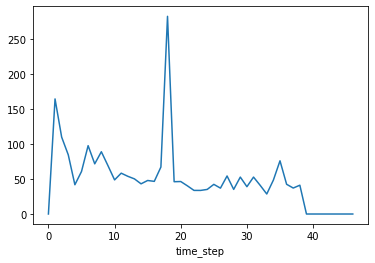

In [65]:
# Plot MBD by timesteps to detect any potential outliers

lag = 1

# Shift the MBD variable 1 timestep, and do a back fill to fill last value in oldest date
all_data[f'mbd_lag_{lag}'] = all_data.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

# Define a ratio of change. We clip it to ensure there are no "Inf" values
all_data['dif'] = (all_data['microbusiness_density'] / all_data[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

# If shifted M<BD is 0, we set the ratio as 0 
all_data.loc[(all_data[f'mbd_lag_{lag}']==0), 'dif'] = 0

# If the shifted MBD is 0, but it has non zero MBD currently, we change it to a fixed value of 1
# This will mark counties which started having micro businesses recently 
all_data.loc[(all_data[f'microbusiness_density']>0) & (all_data[f'mbd_lag_{lag}']==0), 'dif'] = 1

# COnvert to absolute values to signify change
all_data['dif'] = all_data['dif'].abs()

# Group MBD by timestep, and check if there are any significant spikes in certain timestep
all_data.groupby('time_step')['dif'].sum().plot()

In [66]:
# Check for outliers

outliers = [] #Store outlier cfips

cnt = 0 # Store the count of outliers

for county in tqdm(all_data.cfips.unique()):
    indices = (all_data['cfips']==county) # Get data indices
    tmp = all_data.loc[indices].copy().reset_index(drop=True) # Make temp copy
    var = tmp.microbusiness_density.values.copy() #Copy of MBD values
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    # Outlier treatment
    # Iterate through the training timesteps and determine outlier
    for i in range(37+2, 2, -1):
        thr = 0.20*np.mean(var[:i]) #Define threshold as 20%
        difa = abs(var[i]-var[i-1]) #Determine difference from prev. timestep
        
        # If outlier was detected, we scale previous MBDs by current ratio
        # Basically smoothing when outlier is detected. 
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1]) if var[i-1] != 0 else 1
            outliers.append(county)
            cnt+=1
    var[0] = var[1]*0.99
    all_data.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

100%|██████████| 3135/3135 [00:07<00:00, 437.85it/s]


(485, 772)

<AxesSubplot:xlabel='time_step'>

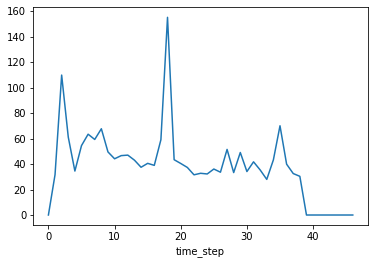

In [67]:
lag = 1

# Shift the MBD variable 1 timestep, and do a back fill to fill last value in oldest date
all_data[f'mbd_lag_{lag}'] = all_data.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

# Define a ratio of change. We clip it to ensure there are no "Inf" values
all_data['dif'] = (all_data['microbusiness_density'] / all_data[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

# If shifted M<BD is 0, we set the ratio as 0 
all_data.loc[(all_data[f'mbd_lag_{lag}']==0), 'dif'] = 0

# If the shifted MBD is 0, but it has non zero MBD currently, we change it to a fixed value of 1
# This will mark counties which started having micro businesses recently 
all_data.loc[(all_data[f'microbusiness_density']>0) & (all_data[f'mbd_lag_{lag}']==0), 'dif'] = 1

# COnvert to absolute values to signify change
all_data['dif'] = all_data['dif'].abs()

# Group MBD by timestep, and check if there are any significant spikes in certain timestep
all_data.groupby('time_step')['dif'].sum().plot()

In [68]:
# Abnormal spike in sum of absolute ratios 

temp = all_data.loc[all_data['time_step'] == 18, ['cfips',f'mbd_lag_ratio_{lag}']]

temp.sort_values(by = (f'mbd_lag_ratio_{lag}'))

,cfips,mbd_lag_ratio_1
125461,48301,-1.000000
67040,28055,-1.000000
144449,55067,-0.921871
8431,5141,-0.764929
15951,12045,-0.764314
...,...,...
26291,16021,3.091290
51624,21215,3.984375
94300,38039,4.083333
82738,32510,12.506111


In [69]:
all_data.loc[all_data['cfips'].isin((32017,32510)),:]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,year,month,time_step,county_num,state_num,mbd_lag_1,mbd_lag_ratio_1,dif
82344,32017_2019-08-01,32017,Lincoln County,Nevada,2019-08-01,65.518309,170.0,0,2019,8,0,1752,28,65.518309,0.000000,0.000000
82345,32017_2019-09-01,32017,Lincoln County,Nevada,2019-09-01,66.180110,160.0,0,2019,9,1,1752,28,65.518309,-0.058824,0.010101
82346,32017_2019-10-01,32017,Lincoln County,Nevada,2019-10-01,72.798124,176.0,0,2019,10,2,1752,28,66.180110,0.100000,0.100000
82347,32017_2019-11-01,32017,Lincoln County,Nevada,2019-11-01,68.248238,165.0,0,2019,11,3,1752,28,72.798124,-0.062500,0.062500
82348,32017_2019-12-01,32017,Lincoln County,Nevada,2019-12-01,70.316371,170.0,0,2019,12,4,1752,28,68.248238,0.030303,0.030303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82762,32510_2023-02-01,32510,Carson City,Nevada,2023-02-01,NaN,NaN,1,2023,2,42,1760,28,6.323248,0.000000,0.000000
82763,32510_2023-03-01,32510,Carson City,Nevada,2023-03-01,NaN,NaN,1,2023,3,43,1760,28,6.323248,0.000000,0.000000
82764,32510_2023-04-01,32510,Carson City,Nevada,2023-04-01,NaN,NaN,1,2023,4,44,1760,28,6.323248,0.000000,0.000000
82765,32510_2023-05-01,32510,Carson City,Nevada,2023-05-01,NaN,NaN,1,2023,5,45,1760,28,6.323248,0.000000,0.000000


### Simple reorder for more sensible data

In [70]:
# Reorder columns
# reorder_cols = ('row_id', 'cfips', 'year', 'month', 'first_day_of_month', 'county', 'state', 'active', 'microbusiness_density')
# all_data = all_data.loc[:,reorder_cols]

# all_data.head()

# Convert target to relative metric SMAPE

Since we are trying to predict the next iteration of MBD, we can use SMAPE formula for calculation

In [71]:
# Shift to bring future values with current
all_data['target'] = all_data.groupby('cfips')['microbusiness_density'].shift(-1)

# Conbvert to ratio similat to the lag ratio previously made
all_data['target'] = (all_data['target']/all_data['microbusiness_density']) - 1

all_data.loc[all_data.cfips == 48269,'microbusiness_density']

124691    2.616740
124692    2.643172
124693    2.643172
124694    2.643172
124695    2.643172
124696    2.643172
124697    2.643172
124698    2.643172
124699    2.643172
124700    2.643172
124701    2.643172
124702    2.643172
124703    2.643172
124704    2.643172
124705    2.643172
124706    2.643172
124707    2.643172
124708    2.643172
124709    2.202643
124710    2.202643
124711    2.202643
124712    2.202643
124713    2.202643
124714    2.202643
124715    2.202643
124716    2.202643
124717    1.762115
124718    1.762115
124719    1.762115
124720    1.762115
124721    1.762115
124722    1.762115
124723    1.762115
124724    1.762115
124725    1.762115
124726    1.762115
124727    1.762115
124728    1.762115
124729    1.762115
124730         NaN
124731         NaN
124732         NaN
124733         NaN
124734         NaN
124735         NaN
124736         NaN
124737         NaN
Name: microbusiness_density, dtype: float64

<AxesSubplot:>

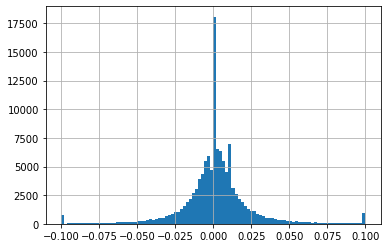

In [72]:
# Ceck distribution of our target variable

all_data['target'].clip(-0.10,0.10).hist(bins = 100)

# Make lag features

Using a premade function from another notebook 
Link - https://www.kaggle.com/code/titericz/better-xgb-baseline

In [73]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [74]:
# Build Features based in lag of target
all_data, feats = build_features(all_data, 'target', 'active', lags = 4)
features = ['state_num']
features += feats
print(features)
all_data.loc[all_data.time_step==38+2, features].head(10)

['state_num', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_num,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
40,0,NaN,NaN,NaN,NaN,0.006152,NaN,NaN,0.011650,0.034969
87,0,NaN,NaN,NaN,NaN,0.002170,NaN,NaN,-0.015431,-0.017278
134,0,NaN,NaN,NaN,NaN,0.020921,NaN,NaN,0.029359,0.033948
181,0,NaN,NaN,NaN,NaN,-0.021367,NaN,NaN,-0.003976,0.010248
228,0,NaN,NaN,NaN,NaN,-0.010949,NaN,NaN,-0.002360,0.033137
275,0,NaN,NaN,NaN,NaN,0.012987,NaN,NaN,0.026145,0.052992
322,0,NaN,NaN,NaN,NaN,0.009036,NaN,NaN,0.036900,0.098454
369,0,NaN,NaN,NaN,NaN,-0.003180,NaN,NaN,0.004429,0.027747
416,0,NaN,NaN,NaN,NaN,-0.040201,NaN,NaN,-0.052608,-0.015697
463,0,NaN,NaN,NaN,NaN,-0.012605,NaN,NaN,-0.012605,0.000338


In [75]:
all_data.columns.values

array(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'is_test', 'year', 'month',
       'time_step', 'county_num', 'state_num', 'mbd_lag_1',
       'mbd_lag_ratio_1', 'dif', 'target', 'act_lag_1', 'mbd_lag_2',
       'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1',
       'mbd_rollmea4_1', 'mbd_rollmea6_1'], dtype=object)

## Cross-Validate both datasets

1. We will check if we have match for all (or most) keys in dataset

Observations:
1. Census data has extra counties included
1. Census data is not available for 2022 (which is logical).
    1. THus we may need to generate some projecttions/estimates for 2022. We can either use same 2021 numbers or determine average growth rate based on bucketed counties


In [76]:
train_cfips = train_base['cfips'].unique()
train_years = train_base['year'].unique()

census_cfips = thin_census_data['cfips'].unique()
census_years = thin_census_data['year'].unique()

KeyError: 'year'

#### Check county IDs

In [ ]:
print("Training data")
print(train_cfips)
print("size = ",train_cfips.shape)

print("\nCensus Data")
print(census_cfips)
print("size = ",census_cfips.shape)

# Print missing from each sets
print("Missing from census data (but are present in training data):")
print(train_cfips[~np.in1d(train_cfips, census_cfips)])

print("Missing from training data (and are available in census):")
print(census_cfips[~np.in1d(census_cfips, train_cfips)])

#### Check years

In [ ]:
print("Training data")
print(train_years)
print("size = ",train_years.shape)

print("\nCensus Data")
print(census_years)
print("size = ",census_years.shape)

# Print missing from each sets
print("Missing from census data (but are present in training data):")
print(train_years[~np.in1d(train_years, census_years)])

print("Missing from training data (and are available in census):")
print(census_years[~np.in1d(census_years, train_years)])

# EDA

As we have some relevant information on the data, we can perform EDA to establish a high level understanding before proceeding.

## EDA - Training data

Visualize the timeline using line charts

### Microbusiness density over time

Since we have few counties doing cnonsiderably better than others (again expected information), we may need to bucket counties into groups for easy managable visualizations

In [ ]:
# Making a copy
eda_train_data = train_base

In [ ]:
# Quick pair plot
import seaborn as sns

sns.pairplot(data = eda_train_data, hue='year')

In [ ]:
# Bucket Counties based on micro density variable
# We will have to tag outliers and then decile the data
# Based on the pair plot, we will tag the entries with 
# We will use deciles for initial view
# Keep in mind, decile ranking assigns first label to lowest decile

# Summarize data to get avergae density for each county over years.
temp_avg_density = eda_train_data.groupby(['cfips']).agg({'microbusiness_density':'mean'}).reset_index()

# Store list of cfips based on graphs
# We will treat average above 30 as an outlier
outlier_cfips = temp_avg_density.loc[temp_avg_density['microbusiness_density'] >= 30.0, ['cfips']]
outlier_cfips.loc[:,'microdensity_buckets'] = "outlier"

# We bucket the rest
normal_cfips = temp_avg_density.loc[~temp_avg_density['cfips'].isin(outlier_cfips['cfips'].unique()),['cfips','microbusiness_density']]
normal_cfips.loc[:,['microdensity_buckets']] = pd.qcut(temp_avg_density['microbusiness_density'],10, labels = False)

# normal_cfips.head()
normal_cfips = normal_cfips.loc[:,["cfips","microdensity_buckets"]]

cfip_density_buckets = pd.concat((normal_cfips, outlier_cfips), axis = 0).reset_index()
# cfip_density_buckets


# Plot for inspection
sns.pairplot(data = temp_avg_density)

In [ ]:
# Assign the average micro business density buckets to data
eda_train_data = pd.merge(left = eda_train_data, right = cfip_density_buckets,on = 'cfips', how = 'left')

# Trying to see how data ends up
# Quick observations
# Outlier buckets seem to have counties that started small (but had relatively higher density to start off with), but have high density over years
# These counties may already have decent population
temp = eda_train_data.groupby(('microdensity_buckets'), as_index = False).agg(min_density = ("microbusiness_density",np.min),max_density = ("microbusiness_density",np.max))
temp

In [ ]:
# Through visual inspection, we need to classify certain counties as outliers to get a better idea of trends
# Quick scatter plot to visualise the outliers

g = sns.FacetGrid(data = eda_train_data,col = 'microdensity_buckets', col_wrap = 3)

g.map(sns.lineplot, "first_day_of_month", "microbusiness_density")

### Active over time

We will check the active attribute and see if we can get some information from it.
Also, since we will not have this attribute available for test set, we will need to figure out a imputation for this variable.

Good idea is to check coorelation with other attributes to make the task easy

In [ ]:
temp_avg_active = eda_train_data.groupby(['cfips'], as_index=False).agg({'active':'mean'})

# Store list of cfips based on graphs
# Difficult to see actual values due to extreme outlier. Remove and recheck

# We will do trial and error to evaluate the best cutoff based on average active businesses
# Looking at granular plots, a good cutoff for active attribute outliers at 20k
outlier_cfips_active = temp_avg_active.loc[temp_avg_active['active'] >= 2.0e4, ['cfips']]

outlier_cfips_active['active_buckets'] = "outlier"
# None here. We will merge it regardless for redundancy
zero_cfips_active = temp_avg_active.loc[temp_avg_active['active'] == 0, 'cfips']

if len(zero_cfips_active) != 0:
    zero_cfips_active['active_buckets'] = "zero"
    outlier_cfips_active = pd.concat((outlier_cfips_active, zero_cfips_active), axis = 0)

# Generate buckets for the remaining counties
temp_avg_active = temp_avg_active.loc[~temp_avg_active['cfips'].isin(outlier_cfips_active['cfips']), :]
temp_avg_active['active_buckets'] = pd.qcut(temp_avg_active['active'],5, labels = False)
temp_avg_active = temp_avg_active.loc[:,['cfips','active_buckets']]

# Final list of buckets
active_buckets = pd.concat((outlier_cfips_active, temp_avg_active))
active_buckets = active_buckets.reset_index(drop="index")

active_buckets

In [ ]:
# Assign the average micro business density buckets to data
eda_train_data = pd.merge(left = eda_train_data, right = active_buckets,on = 'cfips', how = 'left')

# Trying to see how data ends up
# Quick observations
# Outlier buckets seem to have counties that started small (but had relatively higher density to start off with), but have high density over years
# These counties may already have decent population

temp = eda_train_data.groupby(('active_buckets'), as_index = False).agg(min_density = ("active",np.min),max_density = ("active",np.max))
temp

In [ ]:
# Quick scatter plot to visualise the outliers
# sns.lineplot(data = temp, x = "first_day_of_month", y = "active", hue = "active_buckets")
temp = eda_train_data.loc[eda_train_data['active_buckets'] != "outlier",:]
g = sns.FacetGrid(data = temp, col = "active_buckets", col_wrap = 3)
g.map(sns.lineplot, "first_day_of_month", 'active')


## 

## Census Data

We will plot census data and see if we can see a simple way to forecast it

The direct pairplot takes too long to process. We will try and shrink the data a bit by grouping it by states


In [ ]:
# Updating the dataset

eda_census_data = census_data.copy()

In [ ]:
eda_census_data.columns

In [ ]:
# The direct pairplot takes too long to process. We will try and shrink the data a bit by grouping it by states

col_set_2017 = ['cfips', 'pct_bb_2017', 'pct_college_2017', 'pct_foreign_born_2017', 'pct_it_workers_2017', 'median_hh_inc_2017']
col_set_2018 = ['cfips', 'pct_bb_2018', 'pct_college_2018', 'pct_foreign_born_2018', 'pct_it_workers_2018', 'median_hh_inc_2018']
col_set_2019 = ['cfips', 'pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019', 'median_hh_inc_2019']
col_set_2020 = ['cfips', 'pct_bb_2020', 'pct_college_2020', 'pct_foreign_born_2020', 'pct_it_workers_2020', 'median_hh_inc_2020']
col_set_2021 = ['cfips', 'pct_bb_2021', 'pct_college_2021', 'pct_foreign_born_2021', 'pct_it_workers_2021', 'median_hh_inc_2021']


sns.pairplot(data = census_data.loc[:,col_set_2021])



# Notes:

PCT BB is coorelated with past year. Easy to forecast with growth variable

PCR college may be coorelation to median hh income and pct bb
PCT BB and PCT income may have some degree of coorelation



In [ ]:
# thin_census_data
census_data

# Notes for later

1. No 2022 census data. May need to project to get estimates

# RE:Pre-Processing: After validation

Based on observations made, 
1. Census data lacks information for 2022, and needs to be generated/fetched from government website
2. Training data is not lacking any essential information

Steps:
1. Project/impute the 2022 census data into the dataset
2. Join the training set and the census data

#### Projecting census data

We can potentially use a slew of techniques here

### Merge the inputs provided

We will join the 2 datasets together on "cfips" and "year" columns.

In [ ]:
train_base

In [ ]:
train_data = train_base.merge(thin_census_data, on = ["cfips","year"], how = 'left')

# Using merge statament to avoid juggling index of dataframes
# We will validate the row count, which should not increase if join is correct
train_data = pd.merge(left = train_base,right = thin_census_data,how = 'left',on = ['cfips','year'])
train_data